In [53]:
import polars as pl
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import json
import datetime

pl.enable_string_cache()
pl.Config().set_tbl_cols(100)
pl.Config().set_tbl_rows(10)

polars.config.Config

In [54]:
#Map route id to correct route name
route_mapping = {
    3: "2L",
    4: "2R",
    33: "3",
    17: "10",
    18: "11",
    23: "12",
    12: "16",
    13: "17",
    14: "18",
    30: "19",
    29: "21",
    38: "21 Tripper",
    777: "777"
}

#Map hex color to prediction status
color_mapping = {
    "#cf1625": "Early",
    "#39B139": "On Time",
    "#D58803": "Little Late",
    "#f3e413": "Very Late"
}

In [55]:
preds = pl.read_parquet("./data/2024-09-preds.parquet")

preds = preds.with_columns(pl.col("statuscolor").alias("statusName"))
preds = preds.with_columns(pl.col("statusName").replace_strict(color_mapping))

preds

stopID,patternStopID,timePoint,minutes,time,status,schedule,scheduleNumber,statuscolor,direction,equipmentID,routeID,receiveTime,captureTime,__index_level_0__,statusName
i64,i64,bool,i64,str,str,str,str,cat,cat,str,i64,datetime[ns],datetime[ns],i64,str
806,10612,false,1,"""07:00PM""","""07:00PM""","""08:01AM""","""8:00:00-17""","""#f3e413""","""Outbound""","""1102""",13,2024-08-31 11:36:01,2024-09-01 00:00:01,20,"""Very Late"""
807,10613,false,1,"""07:00PM""","""07:00PM""","""08:01AM""","""8:00:00-17""","""#f3e413""","""Outbound""","""1102""",13,2024-08-31 11:36:01,2024-09-01 00:00:01,21,"""Very Late"""
808,10614,false,2,"""07:01PM""","""07:01PM""","""08:02AM""","""8:00:00-17""","""#f3e413""","""Outbound""","""1102""",13,2024-08-31 11:36:01,2024-09-01 00:00:01,22,"""Very Late"""
536,10615,true,3,"""07:02PM""","""07:02PM""","""08:03AM""","""8:00:00-17""","""#f3e413""","""Outbound""","""1102""",13,2024-08-31 11:36:01,2024-09-01 00:00:01,23,"""Very Late"""
545,10616,false,4,"""07:03PM""","""07:03PM""","""08:04AM""","""8:00:00-17""","""#f3e413""","""Outbound""","""1102""",13,2024-08-31 11:36:01,2024-09-01 00:00:01,24,"""Very Late"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
451,10573,false,0,"""07:00PM""","""07:00PM""","""07:02PM""","""19:00:00-1""","""#cf1625""","""Outbound""","""72307""",4,2024-09-30 23:59:46,2024-09-30 23:59:57,98454,"""Early"""
448,10574,true,3,"""07:03PM""","""07:03PM""","""07:05PM""","""19:00:00-1""","""#cf1625""","""Outbound""","""72307""",4,2024-09-30 23:59:46,2024-09-30 23:59:57,98455,"""Early"""
449,10575,false,4,"""07:04PM""","""07:04PM""","""07:06PM""","""19:00:00-1""","""#cf1625""","""Outbound""","""72307""",4,2024-09-30 23:59:46,2024-09-30 23:59:57,98456,"""Early"""


In [56]:
df = pl.read_parquet("./data/2024-09-entries.parquet")
df = df.with_columns(pl.col("routeID").replace_strict(route_mapping))

df

routeID,patternID,equipmentID,tripID,lat,lng,load,capacity,eLoad,blockID,nextStopID,nextStopETA,nextPatternStopID,h,lastStopID,lastPatternStopID,scheduleNumber,inService,onSchedule,trainID,receiveTime,aID,captureTime,direction,seq,lastStopExtID,nextStopExtID,nextStopPctProg,atStop,__index_level_0__
str,i64,str,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,bool,f64,i64,datetime[ns],str,datetime[ns],cat,i64,i64,i64,f64,bool,i64
"""777""",33,"""1001""",null,41.93536,-88.77044,0,0,4,0,0,-1,0,197,491,11402,"""NIS""",false,null,0,2024-08-31 23:59:49,"""35467605078ef4d""",2024-09-01 00:00:01,null,-1,-1,-1,null,false,13
"""777""",9998,"""1002""",null,41.93484,-88.72824,0,0,9,0,0,-1,0,78,0,0,"""NIS""",false,null,0,2024-08-31 15:14:57,"""3546760508796c6""",2024-09-01 00:00:01,null,-1,-1,-1,null,false,14
"""777""",0,"""1003""",null,41.93277,-88.76676,0,0,0,0,0,-1,0,0,0,0,"""NIS""",false,null,0,2024-08-30 04:47:18,"""3546760504518c0""",2024-09-01 00:00:01,null,-1,-1,-1,null,false,15
"""777""",9998,"""1004""",null,41.93481,-88.7283,0,0,15,0,0,-1,0,0,0,0,"""NIS""",false,null,0,2024-08-31 09:43:05,"""35467605056be89""",2024-09-01 00:00:01,null,-1,-1,-1,null,false,16
"""777""",9998,"""1101""",null,41.93486,-88.7282,0,0,0,125,0,-1,0,351,0,0,"""NIS""",false,null,0,2024-08-31 05:17:48,"""3546760504edeed""",2024-09-01 00:00:01,null,-1,-1,-1,null,false,17
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""777""",9998,"""901""",null,41.9488,-88.77107,0,0,56,0,0,-1,0,0,0,0,"""NIS""",false,null,0,2024-09-30 23:59:48,"""3546760505620da""",2024-09-30 23:59:57,null,-1,-1,-1,null,false,33868
"""777""",3,"""902""",null,41.93453,-88.72775,0,16,192,0,0,-1,0,356,0,0,"""NIS""",false,null,0,2024-09-30 16:40:25,"""354676050c652c9""",2024-09-30 23:59:57,null,-1,-1,-1,null,false,33869
"""18""",9998,"""904""",null,41.93484,-88.72816,0,0,126,0,0,-1,0,32,683,10662,"""NIS""",false,null,0,2024-09-30 23:59:49,"""35467605084242c""",2024-09-30 23:59:57,null,-1,-1,-1,null,false,33870


In [57]:
#Load stops data
file = open("./data/stops.json", "r")
stopsData = json.load(file)

stops = pl.DataFrame(stopsData['get_stops'])
stops

rid,rsid,id,name,lat,lng,extID,shortName
i64,i64,i64,str,f64,f64,str,str
3,197057,449,"""Anderson Hall""",41.938465,-88.761086,"""449""","""449"""
3,197056,448,"""Barsema Hall""",41.939774,-88.761009,"""448""","""448"""
3,197054,446,"""Castle Dr. at College Ave.""",41.93412,-88.763115,"""446""","""446"""
3,197053,445,"""Castle Dr. at Montgomery""",41.9324,-88.762863,"""445""","""445"""
3,197044,436,"""Convocation Center Entrance 3""",41.936459,-88.785286,"""436""","""436"""
…,…,…,…,…,…,…,…
38,2491136,768,"""Maple St. at DeKalb County Cou…",41.989391,-88.685707,"""""","""DCC"""
38,2491159,791,"""Meijer Grocery Store (On Deman…",41.98642,-88.711739,"""""","""MGS"""
38,2491157,789,"""Thornwood Dr. & Prairie Rd.""",41.972488,-88.698242,"""""","""PRd"""


In [58]:
#Load patterns data
pattern_mapping = {
    3: "2L",
    4: "2R",
    37: "3",
    17: "10",
    18: "11",
    23: "12",
    12: "16",
    13: "17",
    14: "18",
    33: "19",
    46: "21",
    45: "21 Tripper",
}

#Load patterns json
file = open("./data/patterns.json", "r")
patternsData = json.load(file)

patterns = pl.DataFrame(patternsData['get_patterns'])
patterns = patterns.with_columns(pl.col("id").replace_strict(pattern_mapping, default="None"))
patterns

id,name,extID,type,length,color,encLine,decLine,routes,routeNames,stations,stopIDs
str,str,str,i64,f64,str,str,list[null],list[i64],list[str],list[null],list[i64]
"""2L""","""Route 2L (Full Service)""","""2""",2,5.156097,"""#097138""","""eq}~Fxix|OM?a@@}A??fE?nEAbE?h@…",[],[3],"[""Route 2L""]",[],"[433, 465, … 431]"
"""2R""","""Route 2R Full Service""","""1""",1,5.083211,"""#FFD600""","""qk}~Fn{x|Ow@C{BhAoBp@Em@G}G@_I…",[],[4],"[""Route 2R""]",[],"[431, 451, … 432]"
"""3""","""Route 3 Full Service""","""3""",2,2.793036,"""#58F964""","""kq}~Fxix|Oa@??@sA?@?C?A}C???aC…",[],[33],"[""Route 3""]",[],"[431, 493, … 431]"
"""10""","""Route 10 Full Service""","""10""",3,5.564219,"""#782BC9""","""{q}~Fxix|OuBACfF@jH@xClFkBj@Sj…",[],[17],"[""Route 10""]",[],"[477, 432, … 431]"
"""11""","""Route 11 Full Service""","""11""",2,12.793737,"""#A07D5C""","""mq}~F~ix|O}A?QECKEaPAoACmQGGeR…",[],[18],"[""Route 11""]",[],"[492, 431, … 491]"
…,…,…,…,…,…,…,…,…,…,…,…
"""17""","""Route 17 Full Service""","""17""",2,11.542563,"""#3E5BA6""","""ap}~Fjkx|OHOAYQGu@B_B?K}]?_M`B…",[],[13],"[""Route 17""]",[],"[805, 806, … 805]"
"""18""","""Route 18 Full Service""","""18""",4,14.597877,"""#FFAA00""","""}i`_G|no|OoA}Aa@]gAKCB[~BUp@c@…",[],[14],"[""Route 18""]",[],"[676, 835, … 685]"
"""19""","""Route 19 Full Service""","""19""",4,21.596067,"""#34ADE0""","""cm}~Fj_y|Ol@CRUFW?_@??ESOQ??WI…",[],[30],"[""Route 19""]",[],"[819, 528, … 819]"


In [59]:
stops.rename({"id": "nextStopID"}).select(["nextStopID", "name"]).unique().sort("nextStopID")

nextStopID,name
i64,str
431,"""Student Center"""
432,"""DuSable Turnaround Rt 5 / Rt 1…"
433,"""Lincoln Hall"""
436,"""Convocation Center Entrance 3"""
437,"""Lot C3 at Presidents Blvd"""
…,…
818,"""801 E Gurler Rd (Ferrara Candy…"
819,"""DuSable Turnaround - Rt 18 / R…"
820,"""DuSable Turnaround Rt 2L / 2R"""


In [60]:
#Left join stops to get stop names for nextStopID and lastStopID
df = df.join(stops.rename({"id": "nextStopID"}).select(["nextStopID", "name"]).unique(), on="nextStopID", how="left").rename({"name": "nextStopName"})
df = df.join(stops.rename({"id": "lastStopID"}).select(["lastStopID", "name"]).unique(), on="lastStopID", how="left").rename({"name": "lastStopName"})


In [61]:
df['capacity', 'load', 'eLoad'].unique()

capacity,load,eLoad
i64,i64,i64
0,0,107
16,0,117
16,0,0
0,0,66
16,0,36
…,…,…
0,0,168
0,0,138
16,0,5


In [ ]:
#Filter out the subset of data we want to work with
subset = df.filter(
    (pl.col("routeID") == "2L") &
    (pl.col("inService"))
)

#Add stopChanged column
subset = subset.with_columns(
    (
        (pl.col("nextStopID") == pl.col("lastStopID").shift(-1)).over(
            "equipmentID", order_by="receiveTime"
        )
    ).alias("stopChanged")
)

subset = subset.filter(pl.col("stopChanged")).with_columns(
    (pl.col("nextStopID").shift(1) == pl.col("lastStopID"))
    .over("equipmentID", order_by="receiveTime")
    .alias("nextToLast")
)

#Add timeDiff column
subset = subset.with_columns(
    (pl.col("receiveTime").diff().over("equipmentID", order_by="receiveTime")).alias(
        "timeDiff"
    )
).filter(pl.col("nextToLast"))

subset = subset.with_columns(
    pl.when(pl.col("timeDiff") > pl.duration(hours=12))
    .then(pl.col("timeDiff") - pl.duration(hours=24))
    .when(pl.col("timeDiff") < pl.duration(hours=-12))
    .then(pl.col("timeDiff") + pl.duration(hours=24))
    .otherwise(pl.col("timeDiff"))
    .alias("adjusted_diff")
)

subset

routeID,patternID,equipmentID,tripID,lat,lng,load,capacity,eLoad,blockID,nextStopID,nextStopETA,nextPatternStopID,h,lastStopID,lastPatternStopID,scheduleNumber,inService,onSchedule,trainID,receiveTime,aID,captureTime,direction,seq,lastStopExtID,nextStopExtID,nextStopPctProg,atStop,__index_level_0__,nextStopName,lastStopName,stopChanged,nextToLast,timeDiff,adjusted_diff
str,i64,str,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,bool,f64,i64,datetime[ns],str,datetime[ns],cat,i64,i64,i64,f64,bool,i64,str,str,bool,bool,duration[ns],duration[μs]
"""2L""",3,"""Old_1501""",329,41.93639,-88.77295,0,0,33,0,433,1144,10481,269,820,10502,"""19:00:00-2""",true,-2.0,11414,2024-09-01 00:04:21,"""354676050595540""",2024-09-01 00:04:33,"""Outbound""",3,820,433,75.73482,false,511,"""Lincoln Hall""","""DuSable Turnaround Rt 2L / 2R""",true,true,2m 21s,2m 21s
"""2L""",3,"""Old_1501""",329,41.93701,-88.77538,0,0,33,0,465,1145,10482,359,433,10481,"""19:00:00-2""",true,-2.0,11414,2024-09-01 00:05:11,"""354676050595540""",2024-09-01 00:05:18,"""Outbound""",4,433,465,58.84417,false,592,"""Stadium Dr. at New Hall""","""Lincoln Hall""",true,true,50s,50s
"""2L""",3,"""Old_1501""",329,41.93837,-88.77639,0,0,33,0,466,1146,10483,0,465,10482,"""19:00:00-2""",true,-2.0,11414,2024-09-01 00:06:11,"""354676050595540""",2024-09-01 00:06:19,"""Outbound""",5,465,466,75.90138,false,700,"""Grant North""","""Stadium Dr. at New Hall""",true,true,1m,1m
"""2L""",3,"""Old_1501""",329,41.93801,-88.77836,0,0,33,0,467,1147,10484,180,466,10483,"""19:00:00-2""",true,-2.0,11414,2024-09-01 00:07:21,"""354676050595540""",2024-09-01 00:07:34,"""Outbound""",6,466,467,56.79869,false,835,"""Stevenson North""","""Grant North""",true,true,1m 10s,1m 10s
"""2L""",3,"""Old_1501""",329,41.93784,-88.78103,0,0,33,0,468,1149,10485,180,467,10484,"""19:00:00-2""",true,-3.0,11414,2024-09-01 00:08:12,"""354676050595540""",2024-09-01 00:08:20,"""Outbound""",7,467,468,36.44206,true,916,"""Stevenson South""","""Stevenson North""",true,true,51s,51s
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2L""",3,"""1002""",null,41.93262,-88.76315,0,0,0,0,446,1129,10496,344,445,10495,"""18:30:00-2""",true,-1.0,11380,2024-09-30 23:48:55,"""3546760508796c6""",2024-09-30 23:49:07,"""Outbound""",18,445,446,16.80593,true,32765,"""Castle Dr. at College Ave.""","""Castle Dr. at Montgomery""",true,true,20s,20s
"""2L""",3,"""1002""",null,41.9346,-88.76215,0,0,0,0,447,1130,10497,0,446,10496,"""18:30:00-2""",true,-1.0,11380,2024-09-30 23:50:05,"""3546760508796c6""",2024-09-30 23:50:22,"""Outbound""",19,446,447,60.25767,true,32873,"""Gilbert Way at Art Building""","""Castle Dr. at College Ave.""",true,true,1m 10s,1m 10s
"""2L""",3,"""1002""",null,41.93785,-88.76102,0,0,0,0,448,1132,10498,360,447,10497,"""18:30:00-2""",true,0.0,11380,2024-09-30 23:51:56,"""3546760508796c6""",2024-09-30 23:52:08,"""Outbound""",20,447,448,63.06795,false,33035,"""Barsema Hall""","""Gilbert Way at Art Building""",true,true,1m 51s,1m 51s


In [77]:
subset['adjusted_diff'].describe()

statistic,value
str,str
"""count""","""34826"""
"""null_count""","""0"""
"""mean""","""0:01:54.995779"""
"""min""","""-1 day, 13:44:25"""
"""25%""","""0:00:40"""
"""50%""","""0:00:51"""
"""75%""","""0:01:20"""
"""max""","""11 days, 13:42:50"""


In [81]:
outset = subset.filter(pl.col("adjusted_diff") > pl.duration(hours=1))

outset

routeID,patternID,equipmentID,tripID,lat,lng,load,capacity,eLoad,blockID,nextStopID,nextStopETA,nextPatternStopID,h,lastStopID,lastPatternStopID,scheduleNumber,inService,onSchedule,trainID,receiveTime,aID,captureTime,direction,seq,lastStopExtID,nextStopExtID,nextStopPctProg,atStop,__index_level_0__,nextStopName,lastStopName,stopChanged,nextToLast,timeDiff,adjusted_diff
str,i64,str,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,bool,f64,i64,datetime[ns],str,datetime[ns],cat,i64,i64,i64,f64,bool,i64,str,str,bool,bool,duration[ns],duration[μs]
"""2L""",3,"""1002""",null,41.93612,-88.77054,0,0,0,0,820,951,10502,160,431,10503,"""15:50:00-2""",true,0.0,11370,2024-09-05 20:51:26,"""3546760508796c6""",2024-09-05 20:51:37,"""Outbound""",2,431,820,64.01712,false,5428,"""DuSable Turnaround Rt 2L / 2R""","""Student Center""",true,true,8h 38m 1s,8h 38m 1s
"""2L""",3,"""1702""",342,41.93605,-88.77052,0,0,15,0,820,692,10502,160,431,10503,"""11:30:00-2""",true,-1.0,11355,2024-09-15 16:32:45,"""3546760505ac39c""",2024-09-15 16:32:58,"""Outbound""",2,431,820,65.44092,false,97114,"""DuSable Turnaround Rt 2L / 2R""","""Student Center""",true,true,12d 13h 42m 50s,11d 13h 42m 50s
"""2L""",3,"""1702""",341,41.93643,-88.77015,0,0,23,0,820,632,10502,270,431,10503,"""10:30:00-2""",true,-1.0,11354,2024-09-22 15:32:37,"""3546760505ac39c""",2024-09-22 15:32:46,"""Outbound""",2,431,820,50.69125,false,190912,"""DuSable Turnaround Rt 2L / 2R""","""Student Center""",true,true,1d 18h 30m 54s,18h 30m 54s
"""2L""",3,"""902""",null,41.9358,-88.77041,0,16,19,0,820,419,10502,166,431,10503,"""07:00:00-2""",true,2.0,11049,2024-09-28 11:59:22,"""354676050c652c9""",2024-09-28 11:59:37,"""Outbound""",2,431,820,70.43549,false,206235,"""DuSable Turnaround Rt 2L / 2R""","""Student Center""",true,true,1d 18h 20m 21s,18h 20m 21s
"""2L""",3,"""902""",311,41.9364,-88.77264,0,16,117,0,433,452,10481,269,820,10502,"""07:30:00-2""",true,0.0,11071,2024-09-29 12:32:42,"""354676050c652c9""",2024-09-29 12:32:52,"""Outbound""",3,820,433,70.84205,false,169055,"""Lincoln Hall""","""DuSable Turnaround Rt 2L / 2R""",true,true,7h 38m 23s,7h 38m 23s


In [64]:
#Add a uniform column for nextStopPatternID
subset = subset.with_columns(
    pl.col("nextPatternStopID").alias("patternStopID")
)

#Join the subset on the triple key to get the correct prediction
predSet = subset.join(
    preds,
    on=["equipmentID", "patternStopID", "captureTime"],
    how="inner"
)

#Format the schedule time to be a datetime object
predSet = predSet.with_columns(
    (
        pl.col("receiveTime").dt.convert_time_zone("America/Chicago").dt.strftime("%Y-%m-%d") + " " + pl.col("schedule")
    ).str.strptime(pl.Datetime, format="%Y-%m-%d %I:%M %p").dt.replace_time_zone("America/Chicago")
    .alias("scheduleTime")
)

#Subtract receiveTime and scheduleTime to get the time difference
predSet = predSet.with_columns(
    (pl.col("receiveTime").dt.convert_time_zone("America/Chicago") - pl.col("scheduleTime")).alias("scheduleDiff")
)

#Filter out negative schedule differences
# predSet = predSet.filter(
#     (pl.col("scheduleDiff").dt.total_minutes() >= 0) 
# )

predSet['routeID', 'equipmentID', 'lat', 'lng', 'scheduleNumber', 'receiveTime', 'captureTime', 'lastStopID', 'nextStopID', 'lastStopName', 'nextStopName', 'timeDiff', 'time', 'status', 'schedule', 'scheduleTime', 'scheduleDiff', 'statusName']


routeID,equipmentID,lat,lng,scheduleNumber,receiveTime,captureTime,lastStopID,nextStopID,lastStopName,nextStopName,timeDiff,time,status,schedule,scheduleTime,scheduleDiff,statusName
str,str,f64,f64,str,datetime[ns],datetime[ns],i64,i64,str,str,duration[ns],str,str,str,"datetime[μs, America/Chicago]",duration[μs],str
"""2L""","""Old_1501""",41.93639,-88.77295,"""19:00:00-2""",2024-09-01 00:04:21,2024-09-01 00:04:33,820,433,"""DuSable Turnaround Rt 2L / 2R""","""Lincoln Hall""",2m 21s,"""07:04PM""","""07:04PM""","""07:02PM""",2024-08-31 19:02:00 CDT,2m 21s,"""On Time"""
"""2L""","""Old_1501""",41.93801,-88.77836,"""19:00:00-2""",2024-09-01 00:07:21,2024-09-01 00:07:34,466,467,"""Grant North""","""Stevenson North""",1m 10s,"""07:07PM""","""07:07PM""","""07:05PM""",2024-08-31 19:05:00 CDT,2m 21s,"""On Time"""
"""2L""","""Old_1501""",41.93084,-88.78149,"""19:00:00-2""",2024-09-01 00:12:12,2024-09-01 00:12:22,438,439,"""Norther View Circle""","""Lincoln Hwy. at High Meadows""",2m 20s,"""07:12PM""","""07:12PM""","""07:11PM""",2024-08-31 19:11:00 CDT,1m 12s,"""On Time"""
"""2L""","""Old_1501""",41.93105,-88.76697,"""19:00:00-2""",2024-09-01 00:15:03,2024-09-01 00:15:08,443,444,"""Lincoln Hwy. at Pizza Villa""","""Lincoln Hwy. at Psychology Bui…",1m 11s,"""07:15PM""","""On Time""","""07:15PM""",2024-08-31 19:15:00 CDT,3s,"""On Time"""
"""2L""","""Old_1501""",41.93527,-88.76217,"""19:00:00-2""",2024-09-01 00:17:23,2024-09-01 00:17:39,446,447,"""Castle Dr. at College Ave.""","""Gilbert Way at Art Building""",1m 10s,"""07:18PM""","""07:18PM""","""07:19PM""",2024-08-31 19:19:00 CDT,-1m -37s,"""Early"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2L""","""1002""",41.93801,-88.77836,"""18:30:00-2""",2024-09-30 23:39:14,2024-09-30 23:39:32,466,467,"""Grant North""","""Stevenson North""",1m 20s,"""06:39PM""","""06:39PM""","""06:35PM""",2024-09-30 18:35:00 CDT,4m 14s,"""On Time"""
"""2L""","""1002""",41.93784,-88.78103,"""18:30:00-2""",2024-09-30 23:40:34,2024-09-30 23:40:48,467,468,"""Stevenson North""","""Stevenson South""",1m 20s,"""06:41PM""","""06:41PM""","""06:36PM""",2024-09-30 18:36:00 CDT,4m 34s,"""On Time"""
"""2L""","""1002""",41.93136,-88.78386,"""18:30:00-2""",2024-09-30 23:44:55,2024-09-30 23:45:05,438,439,"""Norther View Circle""","""Lincoln Hwy. at High Meadows""",2m 21s,"""06:46PM""","""06:46PM""","""06:41PM""",2024-09-30 18:41:00 CDT,3m 55s,"""On Time"""


In [65]:
d = pl.lit(str(datetime.date.today()))

data = preds[:2000].with_columns(
    ((d + " " + pl.col("time")).str.to_datetime(format="%Y-%m-%d %I:%M %p") - (d + " " + pl.col("schedule")).str.to_datetime(format="%Y-%m-%d %I:%M %p"))
    .alias("scheduleDiff")
)

data

stopID,patternStopID,timePoint,minutes,time,status,schedule,scheduleNumber,statuscolor,direction,equipmentID,routeID,receiveTime,captureTime,__index_level_0__,statusName,scheduleDiff
i64,i64,bool,i64,str,str,str,str,cat,cat,str,i64,datetime[ns],datetime[ns],i64,str,duration[μs]
806,10612,false,1,"""07:00PM""","""07:00PM""","""08:01AM""","""8:00:00-17""","""#f3e413""","""Outbound""","""1102""",13,2024-08-31 11:36:01,2024-09-01 00:00:01,20,"""Very Late""",10h 59m
807,10613,false,1,"""07:00PM""","""07:00PM""","""08:01AM""","""8:00:00-17""","""#f3e413""","""Outbound""","""1102""",13,2024-08-31 11:36:01,2024-09-01 00:00:01,21,"""Very Late""",10h 59m
808,10614,false,2,"""07:01PM""","""07:01PM""","""08:02AM""","""8:00:00-17""","""#f3e413""","""Outbound""","""1102""",13,2024-08-31 11:36:01,2024-09-01 00:00:01,22,"""Very Late""",10h 59m
536,10615,true,3,"""07:02PM""","""07:02PM""","""08:03AM""","""8:00:00-17""","""#f3e413""","""Outbound""","""1102""",13,2024-08-31 11:36:01,2024-09-01 00:00:01,23,"""Very Late""",10h 59m
545,10616,false,4,"""07:03PM""","""07:03PM""","""08:04AM""","""8:00:00-17""","""#f3e413""","""Outbound""","""1102""",13,2024-08-31 11:36:01,2024-09-01 00:00:01,24,"""Very Late""",10h 59m
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
513,10703,true,1,"""07:14PM""","""07:14PM""","""07:10PM""","""17-0831_1""","""#39B139""","""Outbound""","""904""",17,2024-09-01 00:13:36,2024-09-01 00:13:53,1980,"""On Time""",4m
514,10704,false,2,"""07:15PM""","""07:15PM""","""07:11PM""","""17-0831_1""","""#39B139""","""Outbound""","""904""",17,2024-09-01 00:13:36,2024-09-01 00:13:53,1981,"""On Time""",4m
515,10705,false,2,"""07:15PM""","""07:15PM""","""07:11PM""","""17-0831_1""","""#39B139""","""Outbound""","""904""",17,2024-09-01 00:13:36,2024-09-01 00:13:53,1982,"""On Time""",4m


In [66]:
#Check if the time and status time match or are on time
#The Dateframe should be empty
preds.filter(
    (pl.col("time") != pl.col("status")) &
    (pl.col("status") != "On Time")
)

stopID,patternStopID,timePoint,minutes,time,status,schedule,scheduleNumber,statuscolor,direction,equipmentID,routeID,receiveTime,captureTime,__index_level_0__,statusName
i64,i64,bool,i64,str,str,str,str,cat,cat,str,i64,datetime[ns],datetime[ns],i64,str


In [67]:
#Check if all the status color change togther
(preds.group_by("equipmentID", "captureTime")).agg(pl.col("statuscolor").n_unique())['statuscolor'].value_counts()

statuscolor,count
u32,u32
1,1621559


In [68]:
predSet['scheduleDiff', 'statusName'].describe()

statistic,scheduleDiff,statusName
str,str,str
"""count""","""13930""","""13930"""
"""null_count""","""0""","""0"""
"""mean""","""0:06:07.717157""",null
"""std""",null,null
"""min""","""-1 day, 23:42:18""","""Early"""
"""25%""","""0:02:00""",null
"""50%""","""0:05:50""",null
"""75%""","""0:10:16""",null
"""max""","""0:43:11""","""Very Late"""


In [69]:
#Check if our statusName column is correct by comparing it to the status column
data.group_by("statusName").agg(
    pl.col("scheduleDiff").min().alias("scheduleDiffMin"),
    pl.col("scheduleDiff").max().alias("scheduleDiffMax"),
    pl.col("scheduleDiff").mean().alias("scheduleDiffMean"),
    pl.col("scheduleDiff").median().alias("scheduleDiffMedian"),
)

statusName,scheduleDiffMin,scheduleDiffMax,scheduleDiffMean,scheduleDiffMedian
str,duration[μs],duration[μs],duration[μs],duration[μs]
"""Little Late""",5m,12m,8m 20s,9m
"""On Time""",0µs,7m,2m 23s 309352µs,2m
"""Very Late""",10m,10h 59m,1h 8m 34s 736842µs,1h
"""Early""",-37m,1m,-20m -15s -937500µs,-21m


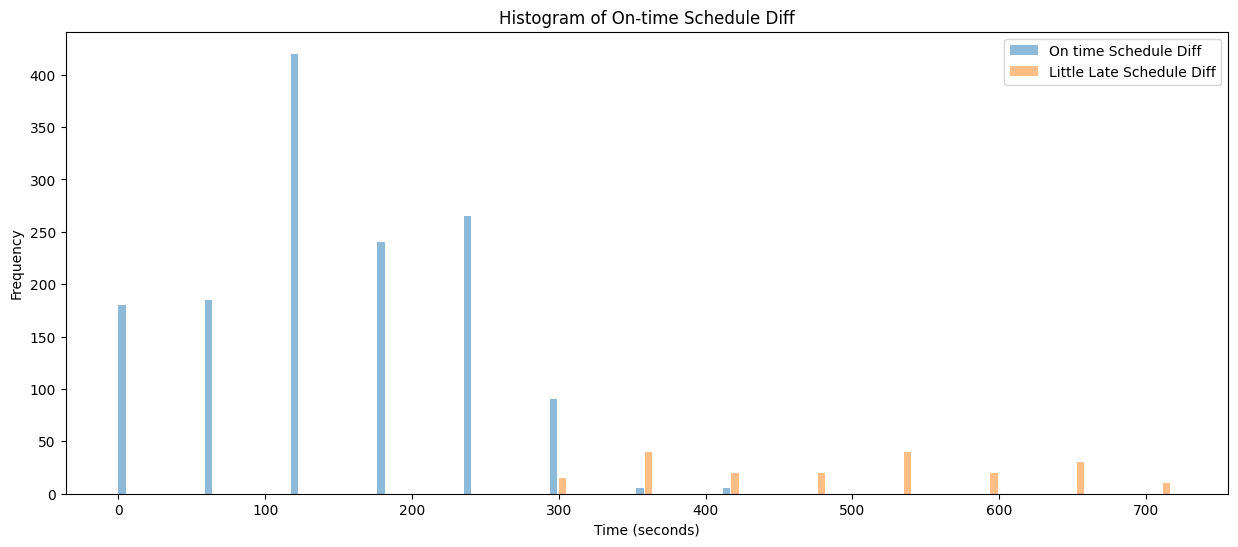

In [70]:
#Pull data for on time and little late statuses
on_time_data = data.filter(pl.col('statusName') == 'On Time')
little_late_data = data.filter(pl.col('statusName') == 'Little Late')

#Convert the scheduleDiff to scheduleDiff_seconds
on_time_data = on_time_data.with_columns(
    (pl.col("scheduleDiff").dt.total_seconds()).alias("scheduleDiff_seconds") 
)

little_late_data = little_late_data.with_columns(
    (pl.col("scheduleDiff").dt.total_seconds()).alias("scheduleDiff_seconds") 
)


# Plot the histograms
plt.figure(figsize=(15, 6))
plt.hist(on_time_data['scheduleDiff_seconds'].to_list(), bins=50, alpha=0.5, width=5, label='On time Schedule Diff')
plt.hist(little_late_data['scheduleDiff_seconds'].to_list(), bins=50, alpha=0.5, width=5, label='Little Late Schedule Diff')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of On-time Schedule Diff')
plt.legend(loc='upper right')
plt.show()

In [71]:
# Define a threshold for overlapping data in minutes
threshold = 5.0 * 60

# Filter out pairs where the difference in scheduleDiff_minutes is within the threshold
overlapping_data = data.filter(pl.col('scheduleDiff').dt.total_seconds() >= threshold).sort('scheduleDiff')

overlapping_data['routeID', 'equipmentID', 'receiveTime', 'schedule','statusName', 'scheduleDiff']

routeID,equipmentID,receiveTime,schedule,statusName,scheduleDiff
i64,str,datetime[ns],str,str,duration[μs]
12,"""72307""",2024-09-01 00:00:08,"""06:58PM""","""On Time""",5m
12,"""72307""",2024-09-01 00:00:08,"""07:03PM""","""On Time""",5m
12,"""72307""",2024-09-01 00:00:08,"""07:05PM""","""On Time""",5m
12,"""72307""",2024-09-01 00:00:08,"""07:05PM""","""On Time""",5m
12,"""72307""",2024-09-01 00:00:08,"""07:07PM""","""On Time""",5m
…,…,…,…,…,…
13,"""1102""",2024-08-31 11:36:01,"""08:01AM""","""Very Late""",10h 59m
13,"""1102""",2024-08-31 11:36:01,"""08:01AM""","""Very Late""",10h 59m
13,"""1102""",2024-08-31 11:36:01,"""08:02AM""","""Very Late""",10h 59m
